# 1. Image processing: Skull Stripping

#### Garrett McCue

Before the images can be fed into the model for training, they must be processed in order to optimize and improve them for the model. One important step in processing is to remove the unnecessary "noise" in the image. This allows the training to be focused on only the relevant information in the image, and in this case would be the brain. Since Alzheimer's Disease is localized in the brain, the skull would be extra information if passed to the model. If the skull would be included the model would be forced to sift through this extra information in order to find the meaningful associations within each disease state and pixel localization. The stripping of the skull provides the model with only the relevant information to problem at hand,  which allows for improvments training efficiency and model performance. 

## Goal:

The goal of this notebook is to walk through the implementation of skull stripping and packaging it up into a resuable format to be used during model training. 

In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# set correct local working directory
ROOT = '/Users/garrettmccue/projects/cnn-alzheimers'
data = f'{ROOT}/data'

os.chdir(ROOT)
os.getcwd()


'/Users/garrettmccue/projects/cnn-alzheimers'

## Data Structure

Two dataset will be used in this project, [ADNI](https://www.kaggle.com/madhucharan/alzheimersdisease5classdatasetadni) and [ALZ](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images), both of them have been sourced from Kaggle for ease of use since they have already been processed from their raw medical image formatting into a .jpeg format. The data is is stored at ~/ROOT/data/ and its organization is displayed in the image below.

![data-struc](/Users/garrettmccue/projects/cnn-alzheimers/diagrams/diagrams-DATA.drawio.png)

In [2]:
def ShowImage(title,img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title(title)
  plt.show()

Image size: (256, 256)


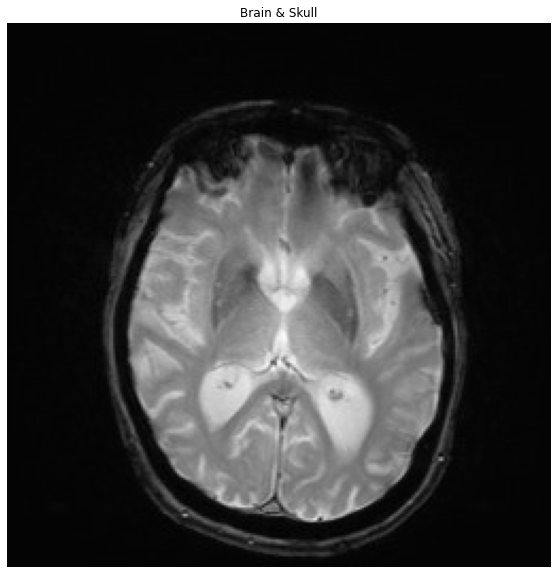

In [11]:
# set the dir to the ADNI AD training dir
folder_dir = f'{data}/ADNI/train/AD'
img = cv2.imread(os.path.join(folder_dir, os.listdir(folder_dir)[0]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(f'Image size: {img.shape}')
ShowImage(title='Brain & Skull', img=img)


In this image we can see the brain as well as the skull. The goal of skull stripping is to create a mask to extract only the brain and removing the skull. This can be easily accomplished by leveraging the fact that the image is grey scale and creating a mask based on the spatial differences in the pixel intensities. To confirm that the pixels can be split into to 2 groups we can plot a distirubtion of the pixel instensities to visually confirm this assumption. 

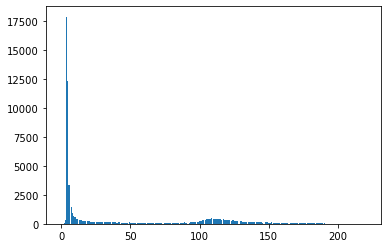

In [6]:
    #Make a histogram of the intensities in the grayscale image
plt.hist(img.ravel(), 256)
plt.show()

we see that the pixel intensities are bimodal, which we can leverage to create a threshold image using [Otsu's Binarization](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)

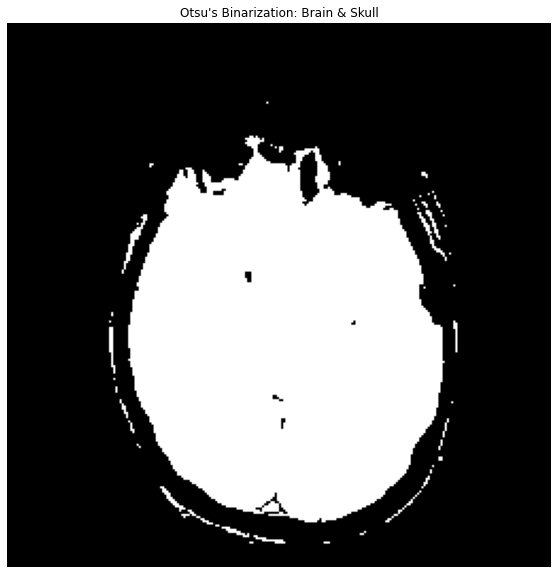

In [15]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
ShowImage('Otsu\'s Binarization: Brain & Skull',thresh)

After Otsu's binarization we can see the brain and the skull are stil. represented in the image. Now we can create a mask of the brain based on the pixel intensities and location. This can be done by extracting the connected components and finding the largest one, which will represent the brain. 

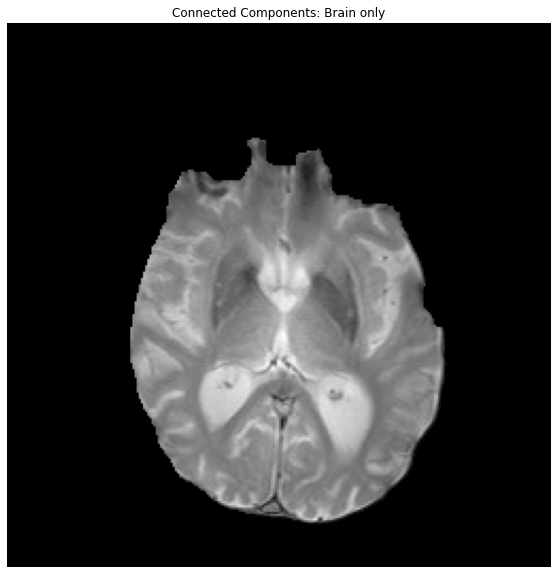

In [8]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

# close the holes in the mask to retain the full brain image using a closing transformation
brain_mask = np.uint8(brain_mask)
kernel = np.ones((8,8),np.uint8)
closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
# pixels that arent apart of the brain are set to 0 so they become black.
brain_out[closing==False] = 0
ShowImage('Connected Components: Brain only', brain_out)

The extraction of the largest connected component to represent the brain was successul in preserving the desired information while removing the "noise". We can now compile all of the steps into a function to make the process callable. 

In [9]:

def strip_skull(img):
    '''
    Purpose: given an image, the binary threshold is found using Otsu's method before computing
        the connected components in order to extract the brain. Potential holes in the mask are
        closed using a closing transformation, before returning the new image without the skull.
    Parameters: 
        -img: brain scan image with skull
    Returns:
        -brain_out: copy of the original image with the skull removed.
    '''
    # ensure the image is in grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #Threshold the image to binary using Otsu's method
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    ret, markers = cv2.connectedComponents(thresh)

    #Get the area taken by each component. Ignore label 0 since this is the background.
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
    #Get label of largest component by area
    largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
    #Get pixels which correspond to the brain
    brain_mask = markers==largest_component

    # close the holes in the mask to retain the full brain image using a closing transformation
    brain_mask = np.uint8(brain_mask)
    kernel = np.ones((8,8),np.uint8)
    closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)

    brain_out = img.copy()
    #In a copy of the original image, clear those pixels that don't correspond to the brain
    # pixels that arent apart of the brain are set to 0 so they become black.
    brain_out[closing==False] = 0
    
    return brain_out

we can test this function to make sure it works as expected with another image.

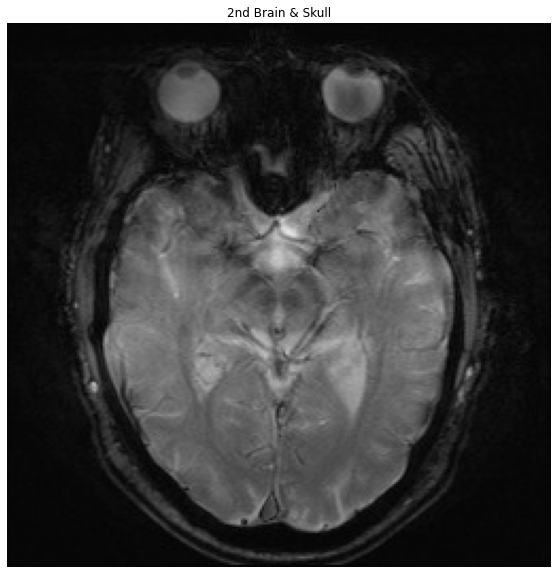

In [19]:
img2 = cv2.imread(os.path.join(folder_dir, os.listdir(folder_dir)[1]))
ShowImage(title='2nd Brain & Skull', img=img2)


Now apply the compiled skull_strip() function to the 2nd image.

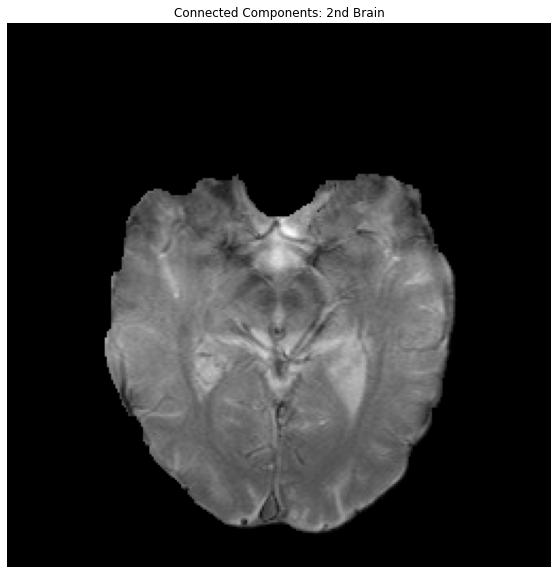

In [20]:
img2 = strip_skull(img2)
ShowImage(title='Connected Components: 2nd Brain', img=img2)

The function worked as expected and can be applied to all images, which will be done on the fly when loading them from their directory for training.  This can be done by using [TensorFlows ImageDataGen's](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) `preprocessing_function` which allows for a custom preprocessing function to be used when generating the data for training and validation. This function is added to the file ROOT/src/data/process.py, to make it accessible easily outside of this notebook, so we should test that it can be succesfully imported and used as desired.

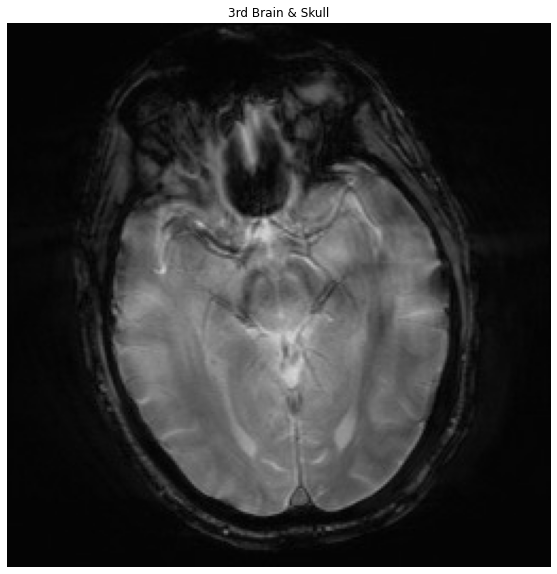

In [21]:
from src.data.process import strip_skull

img3 = cv2.imread(os.path.join(folder_dir, os.listdir(folder_dir)[2]))
ShowImage(title='3rd Brain & Skull', img=img3)


now that the image is loaded we can apply the imported `skull_strip` function to it.

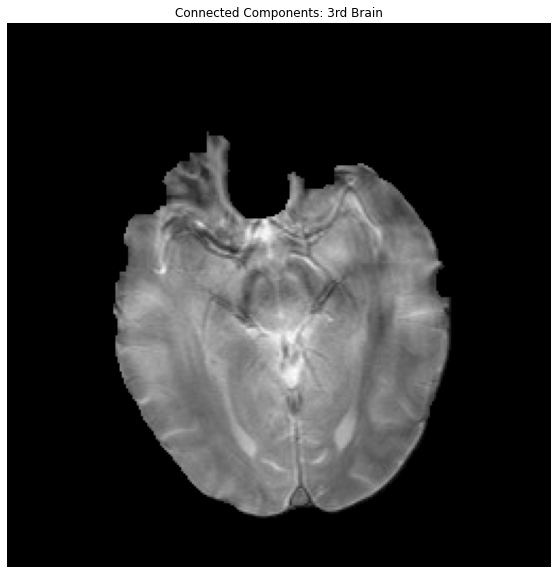

In [22]:
img3 = strip_skull(img3)
ShowImage('Connected Components: 3rd Brain', img3)

Success!